In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from hyperopt import hp, Trials, fmin, tpe, STATUS_OK
from scipy.stats import randint

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_roc_curve, accuracy_score
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder

In [4]:
df = pd.read_csv('fraud_oracle.csv')
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


# EDA

* Primeiro vamos procurar entender a extenção dos dados, seus valores e particularidades.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [6]:
# Vamos dar uma olhada nas colunas do nosso arquivo
print(df.shape)
df.columns

(15420, 33)


Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy'],
      dtype='object')

In [7]:
# Vamos conferir os valores únicos presentes nas colunas
for c in df.columns:
   print(f'A Coluna ({c}), tem os seguintes valores:')
   print(df[c].unique().tolist())

A Coluna (Month), tem os seguintes valores:
['Dec', 'Jan', 'Oct', 'Jun', 'Feb', 'Nov', 'Apr', 'Mar', 'Aug', 'Jul', 'May', 'Sep']
A Coluna (WeekOfMonth), tem os seguintes valores:
[5, 3, 2, 4, 1]
A Coluna (DayOfWeek), tem os seguintes valores:
['Wednesday', 'Friday', 'Saturday', 'Monday', 'Tuesday', 'Sunday', 'Thursday']
A Coluna (Make), tem os seguintes valores:
['Honda', 'Toyota', 'Ford', 'Mazda', 'Chevrolet', 'Pontiac', 'Accura', 'Dodge', 'Mercury', 'Jaguar', 'Nisson', 'VW', 'Saab', 'Saturn', 'Porche', 'BMW', 'Mecedes', 'Ferrari', 'Lexus']
A Coluna (AccidentArea), tem os seguintes valores:
['Urban', 'Rural']
A Coluna (DayOfWeekClaimed), tem os seguintes valores:
['Tuesday', 'Monday', 'Thursday', 'Friday', 'Wednesday', 'Saturday', 'Sunday', '0']
A Coluna (MonthClaimed), tem os seguintes valores:
['Jan', 'Nov', 'Jul', 'Feb', 'Mar', 'Dec', 'Apr', 'Aug', 'May', 'Jun', 'Sep', 'Oct', '0']
A Coluna (WeekOfMonthClaimed), tem os seguintes valores:
[1, 4, 2, 3, 5]
A Coluna (Sex), tem os seguin

# Identificação dos Dados nas Colunas

1. Mounth(obj)
* Abreviação do mês na data do contrato.

2. WeekOfMonth(int64)
* Semana do mês na data do contrato.

3. DayOfWeek(obj)
* Dia do mês na data do contrato.

4. Make(obj)
* Lista de 19 montadoras de veículos.

5. AccidentArea(obj)
* Área do incidente.

6. DayOfWeekClaimed(obj)
* Dia da semana do incidente.
* Temos '0' aqui, então vou precisar olhar com cuidado e elaborar uma solução.

7. MonthClaimed(obj)
* Abreviação do mês do incidente.
* Temos '0' aqui, então vou precisar olhar com cuidado e elaborar uma solução.

8. WeekOfMonthClaimed(int64)
* Semana do mês na data do incidente.

9. Sex(obj)
* Não sei a que se refere, genêro do indivíduo no incidente ou no contrato...

10. MaritalStatus(obj)
* Não sei a que se refere, ao assegurado no contrato ou, ao indivíduo no incidente...

11.Age(int64)
* Não sei a que se refere, idade do indivíduo no incidente ou no contrato...
* Temos '0' aqui, então vou precisar olhar com cuidado e elaborar uma solução.

12. Fault(obj)
* Alegação de culpa, pelo assegurado ou um terceiro.

13. PolicyType(obj)
* Tem duas informações aqui. Categoria do veículo (sport, sedan, Utilitário)
* liability - Responsabilidade, all perils - Outros, collision - Colisão

14. VehicleCategory(obj)
* Categoria do veículo (sport, sedan, Utilitário)

15. VehiclePrice(obj)
* Intervalos de preços para os veículos.

16. FraudFound_P(int64)
* Indica se há fraude na petição
* Valor binário, é o objetivo deste modelo.

17. PolicyNumber(int64)
* Aparenta ser um contador, provável que esteja contando linhas.

18. RepNumber(int64)
* Intervalo de 1 - 16, não sei ao certo a que se refere.

19. Deductible(int64)
* Valor Dedutível

20. DriverRating(int64)
* Aparenta ser uma escala de 1 - 4.
* Acredito que seja um 'rank avaliativo'

21. Days_Policy_Accident(obj)
* Parece ser um intervalo entre o contrato do seguro e a data do incidente.

22. Days_Policy_Claim(obj)
* Parece ser um intervalo entre o contrato do seguro e a data da solicitação.

23. PastNumberOfClaims(obj)
* Número de vezes em que o contrato foi solicitado anteriormente.

24. AgeOfVehicle(obj)
* Idade do veículo.
* Alguns valores estão em intervalos.

25. AgeOfPolicyHolder(obj)
* Intervalo de idade.

26. PoliceReportFiled(obj)
* Indica se um relato foi feito por um autoridade no local do incidente.

27. WitnessPresent(obj)
* Indica a presença de testemunhas no local.

28. AgentType(obj)
* Até aqui não sei ao certo o que significa.

29. NumberOfSuppliments(obj)
* Até aqui não sei ao certo o que significa. 

30. AddressChange_Claim(obj)
* Indica se teve mudança de endereço entre a firmação do contrato e o incidente.

31. NumberOfCars(obj)
* Não sei ao certo ao que se refere, a quantidade de carros envolvidos no incidente,
  ou quantidade de carros que estão cobertos pelo contrato de seguro.

32. Year(int64)
* Ano em que o incidente ocorreu.

33. BasePolicy(obj)
* Tipo de cobertura no contrato. (Responsabilidade, Outros, Colisão)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
WeekOfMonth,15420.0,2.788586,1.287585,1.0,2.00,3.0,4.00,5.0
WeekOfMonthClaimed,15420.0,2.693969,1.259115,1.0,2.00,3.0,4.00,5.0
Age,15420.0,39.855707,13.492377,0.0,31.00,38.0,48.00,80.0
FraudFound_P,15420.0,0.059857,0.237230,0.0,0.00,0.0,0.00,1.0
PolicyNumber,15420.0,7710.500000,4451.514911,1.0,3855.75,7710.5,11565.25,15420.0
RepNumber,15420.0,8.483268,4.599948,1.0,5.00,8.0,12.00,16.0
Deductible,15420.0,407.704280,43.950998,300.0,400.00,400.0,400.00,700.0
DriverRating,15420.0,2.487808,1.119453,1.0,1.00,2.0,3.00,4.0
Year,15420.0,1994.866472,0.803313,1994.0,1994.00,1995.0,1996.00,1996.0


In [9]:
# Vamos observar nossa coluna dependente, o objetivo da construção desse modelo.
df["FraudFound_P"].value_counts()

0    14497
1      923
Name: FraudFound_P, dtype: int64

* Aparentemente são dados bem desbalanceados, os modelos podem sofrer pra identificar FN E FP.

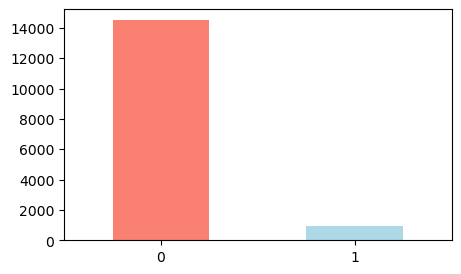

In [10]:
plt.figure(figsize=(5,3))
df["FraudFound_P"].value_counts().plot(kind="bar", color=['salmon', 'lightblue'])
plt.xticks(rotation = 0);

In [11]:
df["Sex"].value_counts()

Male      13000
Female     2420
Name: Sex, dtype: int64

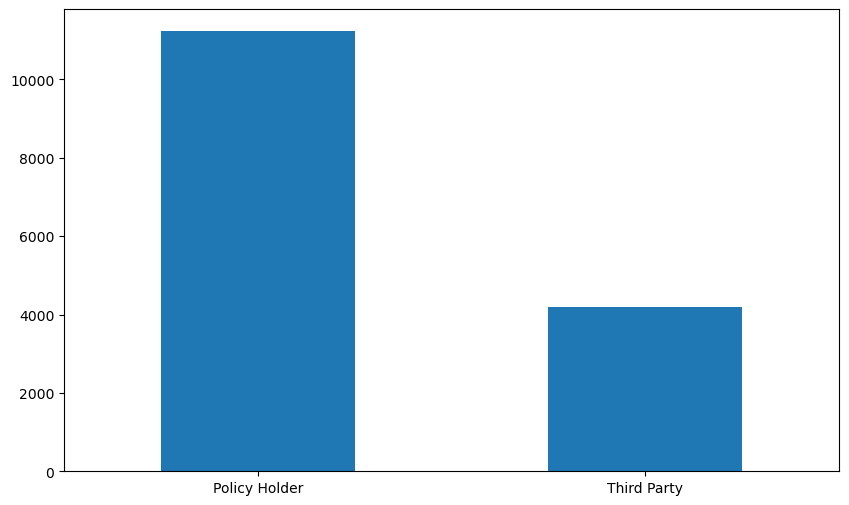

In [12]:
plt.figure(figsize=(10,6))
df["Fault"].value_counts().plot(kind="bar")
plt.xticks(rotation = 0);

In [13]:
df.AccidentArea.value_counts()

Urban    13822
Rural     1598
Name: AccidentArea, dtype: int64

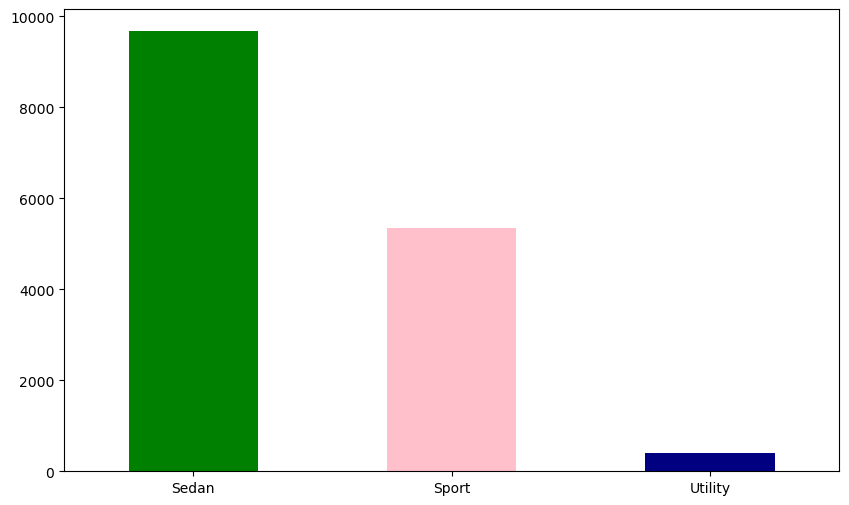

In [14]:
plt.figure(figsize=(10,6))
df.VehicleCategory.value_counts().plot(kind="bar",color=["green","pink","navy"])
plt.xticks(rotation = 0);


In [15]:
df.AgeOfVehicle.value_counts()

7 years        5807
more than 7    3981
6 years        3448
5 years        1357
new             373
4 years         229
3 years         152
2 years          73
Name: AgeOfVehicle, dtype: int64

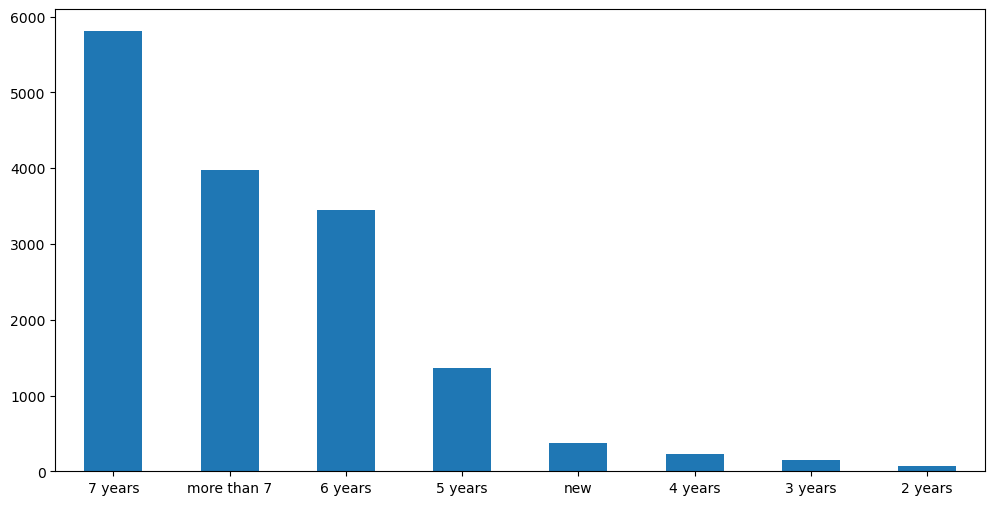

In [16]:
plt.figure(figsize=(12,6))
df.AgeOfVehicle.value_counts().plot(kind="bar")
plt.xticks(rotation=0);

In [17]:
# Vamos verificar as correlações no Dataset
df.corr()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
WeekOfMonth,1.000000,0.275400,-0.004810,-0.011861,-0.007797,0.005283,-0.003993,-0.016817,-0.003906
WeekOfMonthClaimed,0.275400,1.000000,0.001859,-0.005761,0.011665,0.008908,0.005457,-0.000048,0.012175
Age,-0.004810,0.001859,1.000000,-0.029741,0.025944,-0.007063,0.069420,0.001668,0.025197
FraudFound_P,-0.011861,-0.005761,-0.029741,1.000000,-0.020345,-0.007551,0.017348,0.007266,-0.024760
PolicyNumber,-0.007797,0.011665,0.025944,-0.020345,1.000000,0.008990,0.002133,-0.012312,0.936513
RepNumber,0.005283,0.008908,-0.007063,-0.007551,0.008990,1.000000,0.000509,0.011031,0.009338
Deductible,-0.003993,0.005457,0.069420,0.017348,0.002133,0.000509,1.000000,0.003886,-0.001170
DriverRating,-0.016817,-0.000048,0.001668,0.007266,-0.012312,0.011031,0.003886,1.000000,-0.013890
Year,-0.003906,0.012175,0.025197,-0.024760,0.936513,0.009338,-0.001170,-0.013890,1.000000


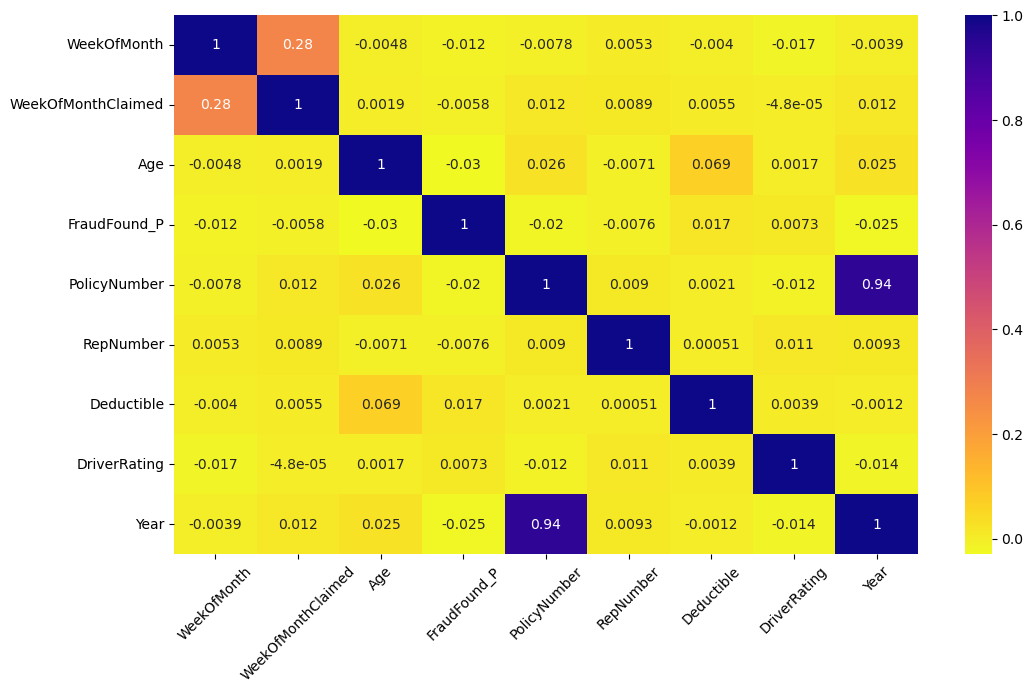

In [18]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(), annot=True, cmap="plasma_r")
plt.xticks(rotation=45);

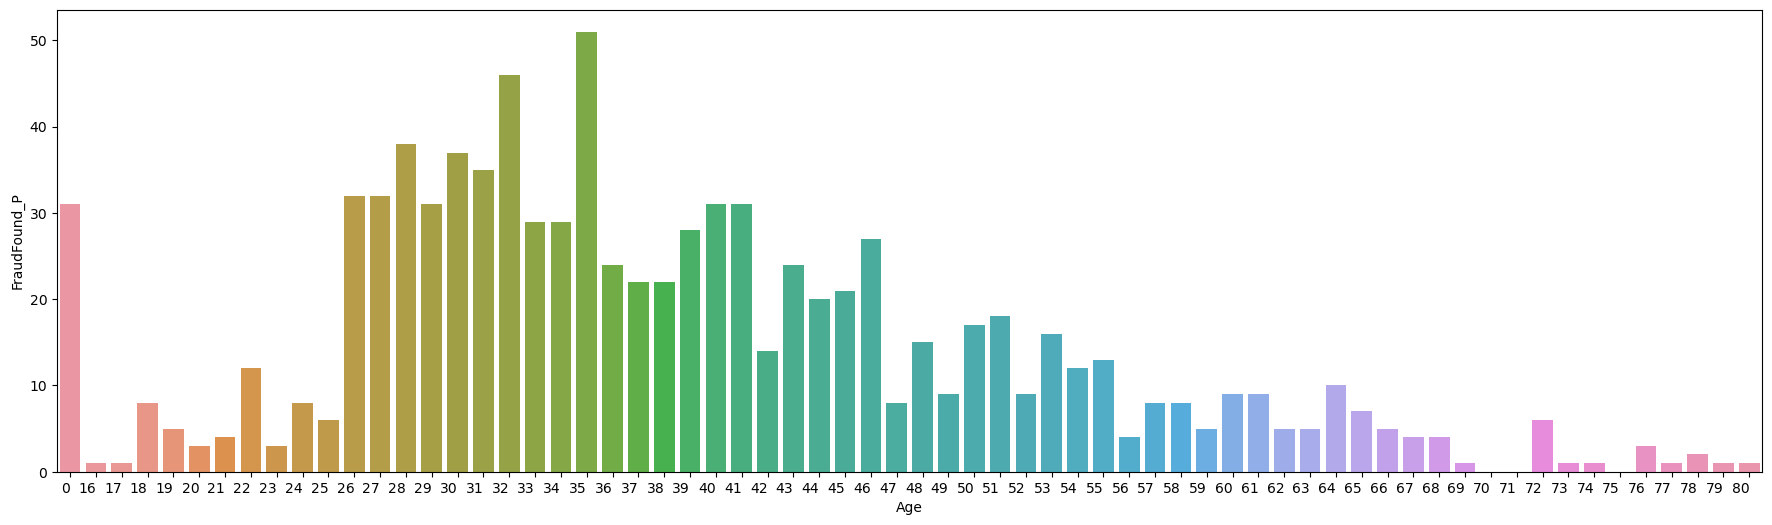

In [19]:
# Vamos verificar as relacões entre as colunas 'Age' e 'FraudFound'
gpd_by_val=df.groupby('Age').agg({'FraudFound_P':'sum'}).reset_index()

fig, (ax1) = plt.subplots(1,1,figsize=(22, 6))
grph =sns.barplot(x='Age', y='FraudFound_P', data = gpd_by_val, ax=ax1)

grph.set_xticklabels(grph.get_xticklabels(),
                    rotation=0,
                    horizontalalignment='right'
                    );

* Parece que os valores de 'Age' que estão zerados são bem expressivos

# Primeiros problemas que vamos trabalhar:

* Avaliar os '0' presentes nos dados.
* Avaliar se a coluna 'PolicyNumber' é de fato um contador.
* Procurar por duplicatas.

In [20]:
# Vou começar com os '0' em 'DayOfWeekClaimed' e 'MonthClaimed'
df.groupby(['MonthClaimed']).size()
df.loc[(df['MonthClaimed']=='0')]



,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
1516,Jul,2,Monday,Honda,Rural,0,0,1,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils


In [21]:
# Aparentemente os '0' estão na mesma linha, vamos checar
df.groupby(['DayOfWeekClaimed']).size()
df.loc[(df['DayOfWeekClaimed']=='0')]

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
1516,Jul,2,Monday,Honda,Rural,0,0,1,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils


In [22]:
# A questão dos valores zerados em 'DayOfWeekClaimed' e 'MonthClaimed' está resolvida
# Vou seguir sem a linha (1516), resetar o index e procurar pela nova linha (1516)
df1 = df.loc[df['DayOfWeekClaimed']!='0']
df1.reset_index(drop=True, inplace=True)
print(len(df),len(df1))
df1.loc[1516]


15420 15419


Month                                 Apr
WeekOfMonth                             1
DayOfWeek                        Saturday
Make                                Mazda
AccidentArea                        Urban
DayOfWeekClaimed                  Tuesday
MonthClaimed                          Apr
WeekOfMonthClaimed                      1
Sex                                Female
MaritalStatus                      Single
Age                                    26
Fault                       Policy Holder
PolicyType              Sedan - Collision
VehicleCategory                     Sedan
VehiclePrice               20000 to 29000
FraudFound_P                            0
PolicyNumber                         1518
RepNumber                              16
Deductible                            400
DriverRating                            3
Days_Policy_Accident         more than 30
Days_Policy_Claim            more than 30
PastNumberOfClaims                 2 to 4
AgeOfVehicle                      

In [23]:
# Agora os valores zerados em 'Age'
df1.loc[(df1['Age']==0)]

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
7,Nov,1,Friday,Honda,Urban,Tuesday,Mar,4,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Collision
13,Jan,5,Friday,Honda,Rural,Wednesday,Feb,1,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Collision
28,Jul,1,Saturday,Honda,Urban,Tuesday,Sep,4,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils
31,Mar,1,Sunday,Honda,Urban,Tuesday,Mar,2,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Collision
58,May,1,Monday,Honda,Rural,Wednesday,May,4,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Liability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15242,May,2,Tuesday,Honda,Urban,Monday,May,3,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1996,Liability
15261,Mar,3,Monday,Honda,Urban,Thursday,Mar,3,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1996,Liability
15273,Apr,3,Monday,Honda,Urban,Tuesday,May,1,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1996,Collision
15378,Jan,2,Tuesday,Honda,Urban,Thursday,Jan,2,Male,Single,...,new,16 to 17,No,No,External,none,1 year,1 vehicle,1996,All Perils


In [24]:
# Aparentemente os dados zerados em 'Age' tem a coluna 'AgeOfPolicyHolder' com o mesmo valor de (16 to 17)
# Vamos checar, se verdadeiro vou preferir substituir pela média a excluir os 319 registros
# Do contrario vamos reduzir os registros
print(len(df1[df1['Age']==0]), len(df1[df1['AgeOfPolicyHolder']=='16 to 17']))

319 319


In [30]:
# É exatamente o caso, todos os registros com valor zerado na coluna 'Age', tem o mesmo valor na coluna 'AgeOfPolicyHolder'
# Caso curioso do Dataset, mas não tem muito o que fazer, vou prosseguir com a substituição dos valores pela média
df1.loc[df1['Age']==0,'Age']=16.5

# Confirmando:
df1.loc[(df1['Age']==0)]

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy


In [43]:
# Vamos contar e somar os valores na coluna 'PolicyNumber'
print(df['PolicyNumber'].sum())

# Aqui vamos contar os valores index do DataFrame
# Usando a soma de Gauss identificamos a somas dos indices
print((len(df.index)/2) * (len(df.index) + 1))

118895910
118895910.0


* Como identificado antes, nossa coluna 'PolicyNumber' é um contador de linhas.

In [87]:
i = [157, 158, 159, 160]
for index in i:
    e = df1['PolicyNumber'][index]
    print(f'Para o Index {index}, o valor do "Policynumber" é: {e}')

Para o Index 157, o valor do "Policynumber" é: 158
Para o Index 158, o valor do "Policynumber" é: 159
Para o Index 159, o valor do "Policynumber" é: 160
Para o Index 160, o valor do "Policynumber" é: 161


* 'PolicyNumber' é o valor do índice +1.

In [25]:
# Proxímo passo, verificar registros duplicados no dataset
df1[df1.duplicated()]

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy


## Separando os dados para montagem do modelo e formatando dados binários
* Vamos separar a coluna 'FraudFound_P' como dependente.
* E o restante dos dados como independente.
* As colunas 'Sex', 'AccidentArea', 'Fault', 'PoliceReportFiled', 'WitnessPresent' e 'AgentType'
  tem valores simples, então vamos atribuir valores binários.

In [26]:
# Vamos dividir os dados em dados dependentes (y_dep), e dados independentes (x_ind)
x_ind = df1.drop('FraudFound_P',axis=1).copy()
y_dep = df1['FraudFound_P'].copy()

* Agora vamos transformar os valores das colunas, 'Sex', 'AccidentArea', 'Fault', 'PoliceReportFiled', 'WitnessPresent' e 'AgentType' para valores binários.

In [27]:
# Vou criar listas com as colunas e seus valores
colunas_bi = ['AccidentArea', 'Sex', 'Fault', 'PoliceReportFiled', 'WitnessPresent', 'AgentType']
val_1 = ['Urban','Female','Policy Holder', 'Yes', 'Yes','External']
val_0 = ['Rural', 'Male', 'Third Party', 'No', 'No', 'Internal']

# Aqui vamos usar um laço para correr a lista 'colunas_bi' e alterar o valor para binário
for i in range(len(colunas_bi)):
    x_ind.loc[x_ind[colunas_bi[i]] == val_1[i], colunas_bi[i]] = 1
    x_ind.loc[x_ind[colunas_bi[i]] == val_0[i], colunas_bi[i]] = 0

In [28]:
# Vamos conferir as substituições
for i in range(len(colunas_bi)):
    print(x_ind.groupby(colunas_bi[i]).size())

AccidentArea
0     1597
1    13822
dtype: int64
Sex
0    12999
1     2420
dtype: int64
Fault
0     4190
1    11229
dtype: int64
PoliceReportFiled
0    14991
1      428
dtype: int64
WitnessPresent
0    15332
1       87
dtype: int64
AgentType
0      241
1    15178
dtype: int64


In [29]:
x_ind.dtypes

Month                    object
WeekOfMonth               int64
DayOfWeek                object
Make                     object
AccidentArea             object
DayOfWeekClaimed         object
MonthClaimed             object
WeekOfMonthClaimed        int64
Sex                      object
MaritalStatus            object
Age                     float64
Fault                    object
PolicyType               object
VehicleCategory          object
VehiclePrice             object
PolicyNumber              int64
RepNumber                 int64
Deductible                int64
DriverRating              int64
Days_Policy_Accident     object
Days_Policy_Claim        object
PastNumberOfClaims       object
AgeOfVehicle             object
AgeOfPolicyHolder        object
PoliceReportFiled        object
WitnessPresent           object
AgentType                object
NumberOfSuppliments      object
AddressChange_Claim      object
NumberOfCars             object
Year                      int64
BasePoli

In [30]:
# Aqui transformamos os valores substituidos em inteiros
for i in range(len(colunas_bi)):
    x_ind[colunas_bi[i]] = x_ind[colunas_bi[i]].astype('int')
x_ind['Age'] = x_ind['Age'].astype('int64')

In [31]:
x_ind.dtypes

Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea             int32
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                      int32
MaritalStatus           object
Age                      int64
Fault                    int32
PolicyType              object
VehicleCategory         object
VehiclePrice            object
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled        int32
WitnessPresent           int32
AgentType                int32
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int64
BasePolicy              object
dtype: o

# Codificando valores dos dados
* As seguintes colunas, precisam ser codificadas para um int, aqui vou usar o sklearn.preprocessing.LabelEncoder():

* Month
* DayOfWeek
* DayOfWeekClaimed
* MonthClaimed
* PastNumberOfClaims
* NumberOfSuppliments
* VehiclePrice
* Day_Policy_Accident
* Days_Policy_Claim
* AgeOfVehicle
* AgeOfPolicyHolder
* AddressChange_Claim
* NumberOfCars
* Make
* MaritalStatus
* PolicyType
* VehicleCategory

In [32]:
# Aqui temos uma lista com os índices das colunas que teram seus valores codificados para inteiros
list_id = [0, 2, 3, 5, 6, 9, 12, 13, 14, 19, 20, 21, 22, 23, 27, 28, 29, 31]
labelencoder = LabelEncoder()

# Laço para corer a lista de índices, e fazer as substituições
for i in list_id:
    x_ind.iloc[:, i] = labelencoder.fit_transform(x_ind.iloc[:, i])

In [33]:
x_ind.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,2,5,6,6,1,5,4,1,1,2,...,1,3,0,0,1,3,0,2,1994,2
1,4,3,6,6,1,1,4,4,0,2,...,4,4,1,0,1,3,3,0,1994,1
2,10,5,0,6,1,4,9,2,0,1,...,5,6,0,0,1,3,3,0,1994,1
3,6,2,2,17,0,0,5,1,0,1,...,6,7,1,0,1,2,3,0,1994,2
4,4,5,1,6,1,5,3,2,1,2,...,3,4,0,0,1,3,3,0,1994,1


In [34]:
x_ind.dtypes

Month                   int32
WeekOfMonth             int64
DayOfWeek               int32
Make                    int32
AccidentArea            int32
DayOfWeekClaimed        int32
MonthClaimed            int32
WeekOfMonthClaimed      int64
Sex                     int32
MaritalStatus           int32
Age                     int64
Fault                   int32
PolicyType              int32
VehicleCategory         int32
VehiclePrice            int32
PolicyNumber            int64
RepNumber               int64
Deductible              int64
DriverRating            int64
Days_Policy_Accident    int32
Days_Policy_Claim       int32
PastNumberOfClaims      int32
AgeOfVehicle            int32
AgeOfPolicyHolder       int32
PoliceReportFiled       int32
WitnessPresent          int32
AgentType               int32
NumberOfSuppliments     int32
AddressChange_Claim     int32
NumberOfCars            int32
Year                    int64
BasePolicy              int32
dtype: object

# Treinamento do modelo, teste e considerações

* Separar os dados em Treino e Teste
* Treinar e testar os modelos
* Considerar sobre os resultados e realizar ajuste se necessário

In [35]:
# Vamos usar aqui 60% do dataset para treino, e 30% para testes
np.random.seed(12)
x_train, x_test, y_train, y_test = train_test_split(x_ind, y_dep, 
                                                    test_size=0.3, 
                                                    random_state=12)

In [36]:
# Vamos analisar nossos frames split e test

print(f"Arquivos de Treino: {x_train.shape} e {y_train.shape}")
print(f"Arquivos de Teste: {x_test.shape} e {y_test.shape}")

Arquivos de Treino: (10793, 32) e (10793,)
Arquivos de Teste: (4626, 32) e (4626,)


* Agora com os dados devidamente tratados e distribuidos, vamos balancear os dados da nossa Classe.

In [37]:
# Aqui vamos usar sklearn.utils.class_weight()
class_weights_dt = dict(zip(np.unique(y_train), 
                         class_weight.compute_class_weight(
                                                class_weight='balanced',
                                                classes= np.unique(y_train),
                                                y = y_train)))
class_weights_dt

{0: 0.531099301249877, 1: 8.53876582278481}

* Vamos treinar, testar e valorar os seguintes modelos para este Dataset:
* Desicion Tree Classifier
* Random Forest Classifier
* XGBoost Classifier

In [38]:
# Vamos criar num dicionário com os modelos que vamos utilizar nos testes.
modelos_comp = {
    "Desicion Tree Classifier" : DecisionTreeClassifier(class_weight=class_weights_dt),
    "Random Forest Classifier" : RandomForestClassifier(class_weight=class_weights_dt),
    "XGB Classifier" : XGBClassifier()
}

In [39]:
# Aqui criamos uma função para treinar e valorar os modelos.
def fit_score(modelo, x_treino, x_teste, y_treino, y_teste):
    np.random.seed(12)
    valor_modelo = {}
    
    # Laço para rodar os modelos.
    for nome, modelo in modelo.items():
        # Treinamento
        modelo.fit(x_treino, y_treino)
        # Valoração dos modelos
        valor_modelo[nome] = modelo.score(x_teste,y_teste)
    return valor_modelo

In [40]:
avaliacao_modelos = fit_score(modelo=modelos_comp,
                        x_treino=x_train,
                        x_teste=x_test,
                        y_treino=y_train,
                        y_teste=y_test)

# Salvamos o resultado num Dataframe
comparativos_modelo = pd.DataFrame(avaliacao_modelos, index=["Accuracy"])
comparativos_modelo

,Desicion Tree Classifier,Random Forest Classifier,XGB Classifier
Accuracy,0.907479,0.937743,0.951362


<AxesSubplot:>

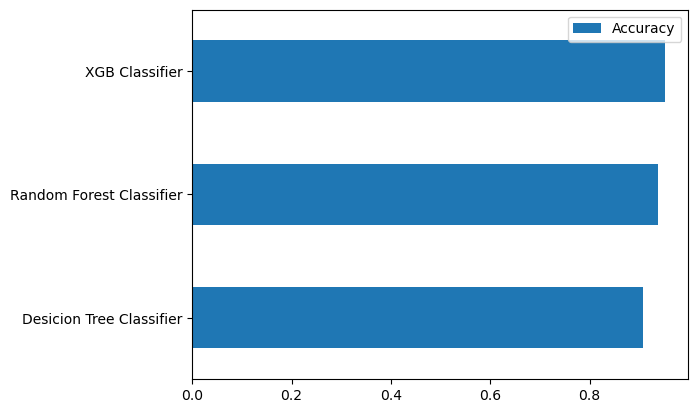

In [41]:
comparativos_modelo.T.plot(kind="barh")

* A princípio, os modelos atigiram valores ótimos, vamos ver o que se consegue com melhorias de Hyperparâmetros.

* Vou usar as ferramentas RandomizedSearchCV E GridSearchCV, para o tune dos modelos.

In [42]:
# Vamos começar com Desicion Tree e RandomizedSearchCV
paran_random_DTC = {"max_depth": [None, 3, 5, 10],
                "min_samples_split": np.arange(2, 20, 2),
                "min_samples_leaf": np.arange(1, 20, 2),
                "criterion": ["gini", "entropy"],} 

# Adicionamos os parametros ao modelo.
np.random.seed(12)
tune_DTC = RandomizedSearchCV(DecisionTreeClassifier(class_weight=class_weights_dt),
                                param_distributions=paran_random_DTC,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Treinamos o modelo
tune_DTC.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeClassifier(class_weight={0: 0.531099301249877,
                                                                  1: 8.53876582278481}),
                   n_iter=20,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
                   verbose=True)

In [43]:
# Checamos os melhores parâmetros
tune_DTC.best_params_

{'min_samples_split': 6,
 'min_samples_leaf': 3,
 'max_depth': None,
 'criterion': 'gini'}

In [44]:
# Testamos o modelo tunado
tune_DTC.score(x_test, y_test)

0.8819714656290532

In [45]:
# Agora Random Foreste com RandomizedSearchCV
paran_random_RFC = {"n_estimators": np.arange(10,500,50),
                    "max_depth": [None, 3, 5, 10],
                    "min_samples_split": np.arange(2, 20, 2),
                    "min_samples_leaf": np.arange(1, 20, 2),
                    } 

# Adicionamos os parametros ao modelo.
np.random.seed(12)
tune_RFC = RandomizedSearchCV(RandomForestClassifier(class_weight=class_weights_dt),
                                param_distributions=paran_random_RFC,
                                cv=5,
                                n_iter=10,
                                verbose=True)

# Treinamos o modelo
tune_RFC.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight={0: 0.531099301249877,
                                                                  1: 8.53876582278481}),
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460])},
                   verbose=True)

In [46]:
# Checamos os melhores parâmetros
tune_RFC.best_params_

{'n_estimators': 460,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_depth': None}

In [47]:
# Testamos o modelo tunado
tune_RFC.score(x_test, y_test)

0.9373108517077389

* Aparentemente DTC e RFC não ganharam muito com RandomizedSearchCV, vamos testar com o GridSearchCV

In [48]:
# Vamos começar com Desicion Tree e GridSearchCV
paran_random_DTC = {"max_depth": [None, 3, 5, 10],
                "min_samples_split": np.arange(2, 20, 2),
                "min_samples_leaf": np.arange(1, 20, 2),
                "criterion": ["gini", "entropy"],} 

# Adicionamos os parametros ao modelo.
np.random.seed(12)
tune_DTC2 = GridSearchCV(DecisionTreeClassifier(class_weight=class_weights_dt),
                                param_grid=paran_random_DTC,
                                cv=5,
                                n_jobs=-1,
                                verbose=True)

# Treinamos o modelo
tune_DTC2.fit(x_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight={0: 0.531099301249877,
                                                            1: 8.53876582278481}),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 5, 10],
                         'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
             verbose=True)

In [49]:
tune_DTC2.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [50]:
tune_DTC2.score(x_test, y_test)

0.9174232598357112

In [51]:
# Agora Random Forest e GridSearchCV
paran_random_RFC = {"n_estimators": np.arange(100,500,150),
                    "max_depth": [None, 3, 5, 10],
                    "min_samples_split": np.arange(2, 12, 2),
                    "min_samples_leaf": np.arange(1, 11, 2),
                    } 

# Adicionamos os parametros ao modelo.
np.random.seed(12)
tune_RFC2 = GridSearchCV(RandomForestClassifier(class_weight=class_weights_dt),
                                param_grid=paran_random_RFC,
                                cv=3,
                                n_jobs=-1,
                                verbose=True)

# Treinamos o modelo
tune_RFC2.fit(x_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight={0: 0.531099301249877,
                                                            1: 8.53876582278481}),
             n_jobs=-1,
             param_grid={'max_depth': [None, 3, 5, 10],
                         'min_samples_leaf': array([1, 3, 5, 7, 9]),
                         'min_samples_split': array([ 2,  4,  6,  8, 10]),
                         'n_estimators': array([100, 250, 400])},
             verbose=True)

In [52]:
tune_RFC2.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 400}

In [53]:
tune_RFC2.score(x_test, y_test)

0.9379593601383485

* Tanto a Decision Tree Classifier, quanto a Random Forest Classifier parecem não ter melhoras significativas,
vamos tentar o XGBoost Classifier

In [54]:
# Aqui temos parâmetros aleátorios para o XGBoostClassifier.
random_param={
    'objective': 'binary:logistic', 
    'base_score': 0.5,
    'booster': 'gbtree',
    'colsample_bylevel' : 1,
    'colsample_bynode' : 1,
    'colsample_bytree' : 1,
    'enable_categorical': False,
    'gamma': hp.uniform('gamma', 0,10),
    'gpu_id': -1,
    'importance_type': None,
    'interaction_constraints': '', 
    'learning_rate': 0.300000012, 
    'max_delta_step': 0,
    'max_depth': hp.randint("max_depth", 10)+3,
    'min_child_weight' : hp.randint('min_child_weight', 4)+1,
    'monotone_constraints': '()',
    'n_estimators': hp.randint('n_estimators', 150)+50,
    'n_jobs': -1,
    'num_parallel_tree':1, 
    'predictor':'auto', 
    'random_state': 0,
    'reg_alpha' : hp.randint('reg_alpha', 10),
    'reg_lambda' : hp.randint('reg_lambda', 10),
    'scale_pos_weight': 1,
    'subsample': 1,
    'tree_method': 'exact',
    'validate_parameters':1,
    'verbosity': None,
    'eval_metric': 'aucpr',
    'eval_metric': "auc",
    'early_stopping_rounds': 10
    }

In [55]:
# Vamos criar uma função para rodar nosso modelo com os parametros do dicionário
def xgb_func(random_param):
        xgb_model= XGBClassifier(**random_param)

        np.random.seed(12)
        valor = [( x_train, y_train), ( x_test, y_test)]

        # Treinamos o modelo
        xgb_model.fit(x_train, y_train,
                eval_set=valor,
                verbose=False)

        # Rodamos o modelo para obter as previsões
        prev = xgb_model.predict(x_test)
        accuracy = accuracy_score(y_test, prev>0.5)
        print ("SCORE:", accuracy)
        return {'loss': -accuracy, 'status': STATUS_OK }

In [58]:
# Aqui vamos rodar nossa função e colher os melhores parâmetros para o tuning do XGBoost
tentativa = Trials()
best_param = fmin(fn = xgb_func,
                        space = random_param,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = tentativa)

SCORE:                                                 
0.9494163424124513                                     
SCORE:                                                                            
0.937094682230869                                                                 
SCORE:                                                                            
0.9388240380458279                                                                
SCORE:                                                                            
0.9392563769995677                                                                
SCORE:                                                                            
0.9433635970600951                                                                
SCORE:                                                                            
0.9509295287505404                                                                
SCORE:                                                    

In [59]:
# Melhores parâmetros encontrados
best_param

{'gamma': 0.49072064251679126,
 'max_depth': 6,
 'min_child_weight': 0,
 'n_estimators': 126,
 'reg_alpha': 0,
 'reg_lambda': 8}

In [60]:
# Aqui vamos substituir os parâmetros anteriores pelos novos encontrados
xgb_model_tuned = XGBClassifier(
    objective= 'binary:logistic',
    base_score= 0.5, 
    booster= 'gbtree', 
    colsample_bylevel= 1, 
    colsample_bynode= 1, 
    colsample_bytree= 1, 
    enable_categorical= False, 
    gamma= best_param['gamma'], 
    gpu_id= -1, 
    importance_type= None, 
    interaction_constraints= '', 
    learning_rate= 0.300000012, 
    max_delta_step= 0, 
    max_depth= 8, 
    min_child_weight= best_param['min_child_weight'], 
    monotone_constraints= '()',
    n_estimators= best_param['n_estimators'], 
    n_jobs= 4, 
    num_parallel_tree= 1, 
    predictor= 'auto', 
    random_state= 0, 
    reg_alpha= best_param['reg_alpha'], 
    reg_lambda= best_param['reg_lambda'], 
    scale_pos_weight= 1, 
    subsample= 1, 
    tree_method= 'exact', 
    validate_parameters= 1, 
    verbosity= None, 
    eval_metric= 'aucpr'
)

In [62]:
# Aqui treinamos e rodamos nosso novo modelo
xgb_model_final = xgb_model_tuned.fit(x_train, y_train)
y_prevs = xgb_model_final.predict(x_test)
tx_acerto = accuracy_score(y_test, y_prevs)
tx_acerto

0.9504971897968006

## Aqui vamos além da Accuracy, vamos analisar o modelo mais a fundo
* Matrix Confusion
* ROC curve e AUC Score
* Precision
* Recall
* F1-Score

c:\Users\gibso\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


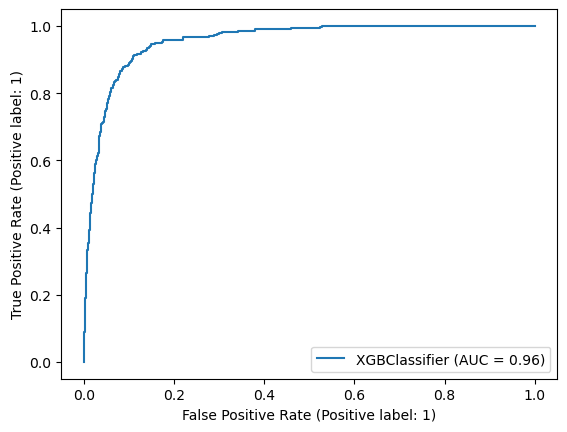

In [63]:
plot_roc_curve(xgb_model_final, x_test,y_test);

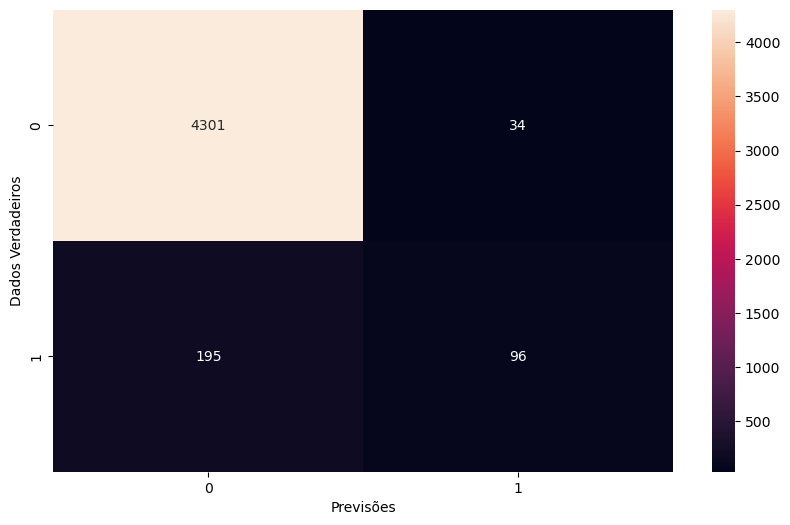

In [64]:
# Vamos por o resultado numa Matriz
def matrix_conf(y_test, y_prevs):
    fix, ax = plt.subplots(figsize=(10,6))
    ax = sns.heatmap(confusion_matrix(y_test, y_prevs),
                     annot=True,
                     cbar=True,
                     fmt="g");
    plt.xlabel("Previsões")
    plt.ylabel("Dados Verdadeiros")

matrix_conf(y_test, y_prevs) 

In [65]:
print(classification_report(y_test,y_prevs))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      4335
           1       0.74      0.33      0.46       291

    accuracy                           0.95      4626
   macro avg       0.85      0.66      0.72      4626
weighted avg       0.94      0.95      0.94      4626



* O modelo parece ter problemas para identificar Falsos Negativos, isso se deve aos dados desbalanceados. 
Apesar disso, o modelo perfomou razoavelmente bem.

In [66]:
# Aqui temos os coeficientes das variáveis independentes.
xgb_model_final.feature_importances_

array([0.03754376, 0.0176735 , 0.02072775, 0.01790653, 0.02032488,
       0.01973722, 0.03749403, 0.01676744, 0.01640821, 0.01294487,
       0.01955608, 0.26454574, 0.02191259, 0.        , 0.01801096,
       0.03722459, 0.01652727, 0.03426196, 0.01670376, 0.01528219,
       0.0140405 , 0.0198526 , 0.01907229, 0.0187933 , 0.01019424,
       0.00992939, 0.00703492, 0.02131313, 0.04068946, 0.01897659,
       0.        , 0.15855028], dtype=float32)

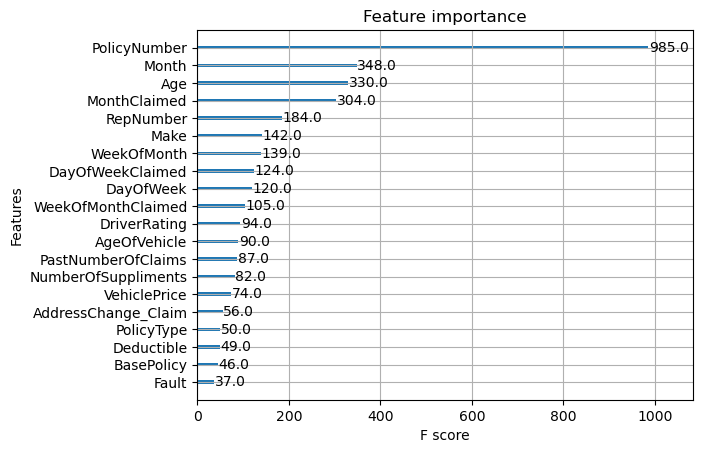

In [67]:
# Aqui temos o F-score para as 20 variáveis mais determinanates no modelo.
plot_importance(xgb_model_final, max_num_features=20);

In [68]:
# Aqui criamos um Dataframe com os dados das variáveis e suas importâncias no modelo.
def plot_var_import(columns, importances, n=20):
    df_feat = (pd.DataFrame({"features":columns,
                             "features_importances": importances})
          .sort_values("features_importances",ascending=False)
          .reset_index(drop=True))
    
    # Vamos imprimir nosso Dataframe num gráfico
    fig, ax = plt.subplots(figsize=(12,7))
    ax.barh(df_feat["features"][:n], df_feat["features_importances"][:20])
    ax.set_ylabel("Variáveis")
    ax.set_xlabel("Importância ao Modelo")
    ax.invert_yaxis()

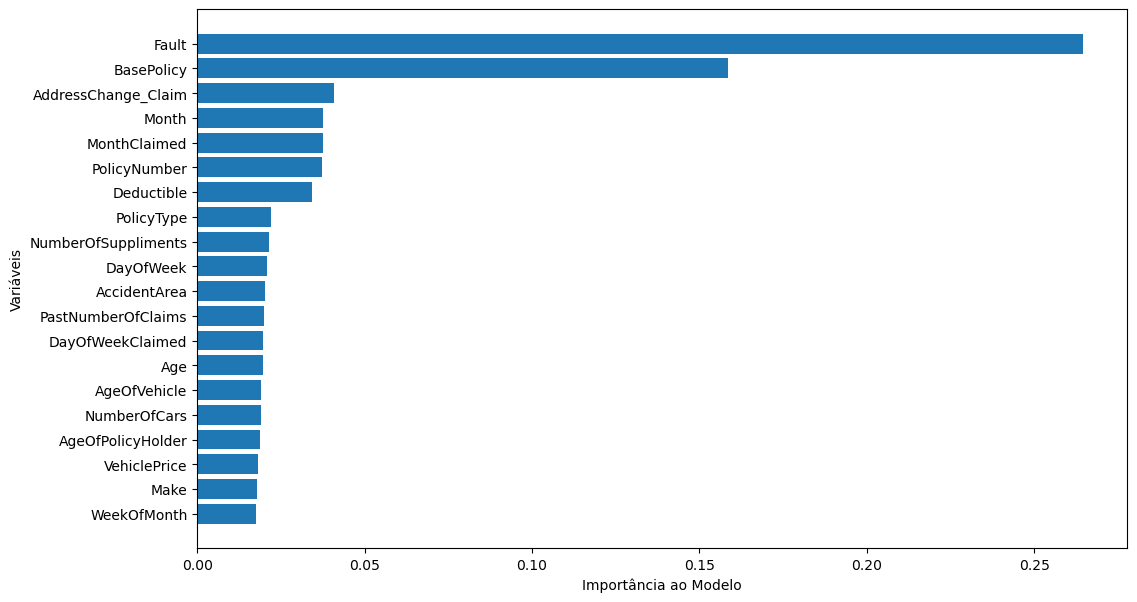

In [69]:
plot_var_import(x_train.columns, xgb_model_final.feature_importances_)

## Consideração Final

* Usamos alguns algoritimos para os modelos e melhorias dos seus parâmetros, o XGboost teve a melhor performace neste Dataset, levando em consideração que a Classe em questão no Dataset estava bem desbalanceada.